In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import datetime as dt
from datetime import datetime
sns.set_style('whitegrid')
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import os

In [2]:
os.chdir("C:/Users/user/Desktop/23-2/trade_machine")

my_df : 임의로 전처리단계를 거친 데이터
 - datetime이 일정하지 않음 <- 거래가 발생할 때마다 데이터를 수집했기 때문.  
 -> datetime을 기준으로 일단 1초씩 묶을 필요가 있음  
 -> next 10min의 volatility의 prediction이므로 whole_data는 남겨놓고, window_size와 prediction_period를 조정하여 모델링 진행  
 
  

In [3]:
my_df = pd.read_csv('final_data.csv')
my_df

,datetime,opening_price,high_price,low_price,trade_price,prev_closing_price,change_price,signed_change_price,change_rate,signed_change_rate,...,min_bid_size,mean_bid_size,std_bid_size,ask_wall_exists,bid_wall_exists,ask_wall,bid_wall,imbalance,mid_price,spread
0,2022-12-16 21:05:37,22952000.0,23050000.0,22500000.0,22568000.0,22942000.0,374000.0,-374000.0,0.016302,-0.016302,...,0.000441,2.889731,9.440261,1.0,1.0,2.299561,36.872502,0.775170,22569000.0,2000.0
1,2022-12-16 21:05:41,22952000.0,23050000.0,22500000.0,22568000.0,22942000.0,374000.0,-374000.0,0.016302,-0.016302,...,0.000441,2.868169,9.446063,1.0,1.0,2.299561,36.872502,0.773854,22569000.0,2000.0
2,2022-12-16 21:05:42,22952000.0,23050000.0,22500000.0,22569500.0,22942000.0,372500.0,-372500.0,0.016237,-0.016237,...,0.000441,2.901809,9.438742,1.0,1.0,2.282840,36.872502,0.781490,22569000.0,2000.0
3,2022-12-16 21:05:44,22952000.0,23050000.0,22500000.0,22570000.0,22942000.0,372000.0,-372000.0,0.016215,-0.016215,...,0.000441,2.949655,9.427963,1.0,1.0,2.274480,36.872502,0.798291,22569000.0,2000.0
4,2022-12-16 21:05:45,22952000.0,23050000.0,22500000.0,22570000.0,22942000.0,372000.0,-372000.0,0.016215,-0.016215,...,0.000441,2.949665,9.427960,1.0,1.0,2.274480,36.872502,0.803821,22569000.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075431,2023-01-21 06:18:06,26208000.0,27687000.0,26101000.0,27515200.0,26205000.0,1310200.0,1310200.0,0.049998,0.049998,...,0.000182,0.582946,0.934549,1.0,1.0,2.662244,3.045101,0.548655,27516000.0,4000.0
1075432,2023-01-21 06:18:07,26208000.0,27687000.0,26101000.0,27518000.0,26205000.0,1313000.0,1313000.0,0.050105,0.050105,...,0.000182,0.476653,0.841520,1.0,1.0,2.662244,3.061531,0.475226,27516000.0,4000.0
1075433,2023-01-21 06:18:08,26208000.0,27687000.0,26101000.0,27514000.0,26205000.0,1309000.0,1309000.0,0.049952,0.049952,...,0.000182,0.449395,0.800324,1.0,1.0,2.662244,2.952673,0.417306,27516000.0,4000.0
1075434,2023-01-21 06:18:09,26208000.0,27687000.0,26101000.0,27514000.0,26205000.0,1309000.0,1309000.0,0.049952,0.049952,...,0.000182,0.389881,0.751391,1.0,1.0,2.697844,2.859958,0.407096,27516000.0,4000.0


In [4]:
my_df.columns

Index(['datetime', 'opening_price', 'high_price', 'low_price', 'trade_price',
       'prev_closing_price', 'change_price', 'signed_change_price',
       'change_rate', 'signed_change_rate', 'trade_volume', 'acc_trade_volume',
       'acc_trade_volume_24h', 'acc_trade_price', 'acc_trade_price_24h',
       'trade_date', 'trade_timestamp', 'acc_ask_volume', 'acc_bid_volume',
       'volatility', 'price_change', 'price_increase',
       'trade_price_mean_10min', 'volume_difference', 'timestamp_y',
       'total_ask_size', 'total_bid_size', 'average_ask_price',
       'average_bid_price', 'price_range_ask', 'price_range_bid',
       'max_ask_size', 'min_ask_size', 'mean_ask_size', 'std_ask_size',
       'max_bid_size', 'min_bid_size', 'mean_bid_size', 'std_bid_size',
       'ask_wall_exists', 'bid_wall_exists', 'ask_wall', 'bid_wall',
       'imbalance', 'mid_price', 'spread'],
      dtype='object')

In [5]:
my_df.drop(columns=['ask_wall_exists','bid_wall_exists'], inplace=True)

In [6]:
# 'datetime'을 datetime 타입으로 변환
my_df['datetime'] = pd.to_datetime(my_df['datetime'])

# 'datetime'을 인덱스로 설정
my_df.set_index('datetime', inplace=True)

# 1분 빈도로 리샘플링
resampled_df = my_df.resample('5T').asfreq()  

# 결측값 보간
interpolated_df = resampled_df.interpolate(method='linear')


In [7]:
interpolated_df.reset_index(inplace=True)
interpolated_df

,datetime,opening_price,high_price,low_price,trade_price,prev_closing_price,change_price,signed_change_price,change_rate,signed_change_rate,...,std_ask_size,max_bid_size,min_bid_size,mean_bid_size,std_bid_size,ask_wall,bid_wall,imbalance,mid_price,spread
0,2022-12-16 21:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-16 21:10:00,22952000.0,23050000.0,22500000.0,2.255300e+07,22942000.0,3.890000e+05,-3.890000e+05,0.016956,-0.016956,...,0.786377,37.109543,0.004347,2.912438,9.482450,2.276038,37.109543,0.768224,2.255850e+07,11000.000000
2,2022-12-16 21:15:00,22952000.0,23050000.0,22500000.0,2.255733e+07,22942000.0,3.846667e+05,-3.846667e+05,0.016767,-0.016767,...,0.808144,37.011604,0.001102,2.749841,9.493283,2.548174,37.011604,0.760555,2.255900e+07,10000.000000
3,2022-12-16 21:20:00,22952000.0,23050000.0,22500000.0,2.255500e+07,22942000.0,3.870000e+05,-3.870000e+05,0.016869,-0.016869,...,0.563976,37.043196,0.038816,3.231262,9.390504,1.663480,37.043196,0.829231,2.255450e+07,1000.000000
4,2022-12-16 21:25:00,22952000.0,23050000.0,22500000.0,2.257000e+07,22942000.0,3.720000e+05,-3.720000e+05,0.016215,-0.016215,...,0.653717,23.904332,0.000444,2.055579,6.069353,2.274480,23.904332,0.758975,2.257050e+07,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10186,2023-01-21 05:55:00,26208000.0,27589000.0,26101000.0,2.758473e+07,26205000.0,1.379733e+06,1.379733e+06,0.052652,0.052652,...,1.158769,1.619728,0.000544,0.292135,0.470433,4.455219,1.619728,0.361287,2.758483e+07,2333.333333
10187,2023-01-21 06:00:00,26208000.0,27589000.0,26101000.0,2.752183e+07,26205000.0,1.316833e+06,1.316833e+06,0.050251,0.050251,...,0.877964,15.027292,0.000364,1.595594,3.750083,3.087079,15.027292,0.808994,2.752150e+07,1000.000000
10188,2023-01-21 06:05:00,26208000.0,27590000.0,26101000.0,2.758150e+07,26205000.0,1.376500e+06,1.376500e+06,0.052528,0.052528,...,0.880486,2.135250,0.001863,0.410378,0.602125,3.295072,2.135250,0.437967,2.756092e+07,38500.000000
10189,2023-01-21 06:10:00,26208000.0,27687000.0,26101000.0,2.760500e+07,26205000.0,1.400000e+06,1.400000e+06,0.053425,0.053425,...,0.772215,1.638149,0.000181,0.380625,0.496003,2.359497,1.638149,0.386386,2.760450e+07,1000.000000


In [8]:
interpolated_df.isna().sum()

datetime                  0
opening_price             1
high_price                1
low_price                 1
trade_price               1
prev_closing_price        1
change_price              1
signed_change_price       1
change_rate               1
signed_change_rate        1
trade_volume              1
acc_trade_volume          1
acc_trade_volume_24h      1
acc_trade_price           1
acc_trade_price_24h       1
trade_date                1
trade_timestamp           1
acc_ask_volume            1
acc_bid_volume            1
volatility                1
price_change              1
price_increase            1
trade_price_mean_10min    1
volume_difference         1
timestamp_y               1
total_ask_size            1
total_bid_size            1
average_ask_price         1
average_bid_price         1
price_range_ask           1
price_range_bid           1
max_ask_size              1
min_ask_size              1
mean_ask_size             1
std_ask_size              1
max_bid_size        

In [9]:
# 첫 번째와 두 번째 행을 제거
interpolated_df = interpolated_df.iloc[2:]


In [10]:
my_df = interpolated_df.copy()

In [11]:
my_df.columns

Index(['datetime', 'opening_price', 'high_price', 'low_price', 'trade_price',
       'prev_closing_price', 'change_price', 'signed_change_price',
       'change_rate', 'signed_change_rate', 'trade_volume', 'acc_trade_volume',
       'acc_trade_volume_24h', 'acc_trade_price', 'acc_trade_price_24h',
       'trade_date', 'trade_timestamp', 'acc_ask_volume', 'acc_bid_volume',
       'volatility', 'price_change', 'price_increase',
       'trade_price_mean_10min', 'volume_difference', 'timestamp_y',
       'total_ask_size', 'total_bid_size', 'average_ask_price',
       'average_bid_price', 'price_range_ask', 'price_range_bid',
       'max_ask_size', 'min_ask_size', 'mean_ask_size', 'std_ask_size',
       'max_bid_size', 'min_bid_size', 'mean_bid_size', 'std_bid_size',
       'ask_wall', 'bid_wall', 'imbalance', 'mid_price', 'spread'],
      dtype='object')

In [12]:
eda_df = my_df.copy()

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# MinMaxScaler 객체 초기화
scaler = StandardScaler()

# DataFrame 스케일링
eda_scaled = pd.DataFrame(scaler.fit_transform(eda_df.drop(['datetime'], axis=1)), columns=eda_df.drop(['datetime'], axis=1).columns)

# 결과 확인
print(eda_scaled.head())

   opening_price  high_price  low_price  trade_price  prev_closing_price  \
0       0.233542    0.159086   0.056157    -0.025767            0.227256   
1       0.233542    0.159086   0.056157    -0.027065            0.227256   
2       0.233542    0.159086   0.056157    -0.018717            0.227256   
3       0.233542    0.159086   0.056157    -0.026509            0.227256   
4       0.233542    0.159086   0.056157    -0.021500            0.227256   

   change_price  signed_change_price  change_rate  signed_change_rate  \
0      0.965743            -1.584788     1.017156           -1.617978   
1      0.976420            -1.593288     1.028342           -1.626729   
2      0.907782            -1.538646     0.956432           -1.570467   
3      0.971844            -1.589645     1.023548           -1.622979   
4      0.930661            -1.556860     0.980402           -1.589221   

   trade_volume  ...  std_ask_size  max_bid_size  min_bid_size  mean_bid_size  \
0     -0.380971  ...   

In [14]:
vol = eda_scaled['volatility'].tolist()
trade_price = eda_scaled['trade_price'].tolist()

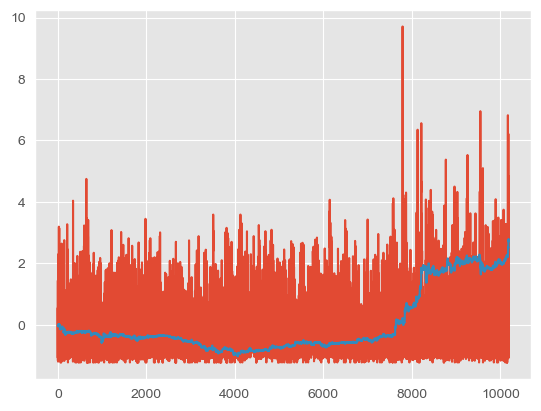

In [15]:
plt.plot(vol)
plt.plot(trade_price)

In [16]:
my_df.drop(columns=['trade_date', 'trade_timestamp', 'timestamp_y', 
                'opening_price', 'high_price', 'low_price', 'trade_price', 'prev_closing_price'],inplace=True)

In [17]:
my_df.corr()

C:\Users\user\AppData\Local\Temp\ipykernel_12636\1718992811.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  my_df.corr()


,change_price,signed_change_price,change_rate,signed_change_rate,trade_volume,acc_trade_volume,acc_trade_volume_24h,acc_trade_price,acc_trade_price_24h,acc_ask_volume,...,std_ask_size,max_bid_size,min_bid_size,mean_bid_size,std_bid_size,ask_wall,bid_wall,imbalance,mid_price,spread
change_price,1.000000,0.658908,0.996770,0.639582,0.001621,0.722771,0.655087,0.718026,0.642646,0.686966,...,-0.030778,0.016823,-0.030577,0.003448,0.015769,-0.026826,0.016823,0.053288,0.398101,0.034500
signed_change_price,0.658908,1.000000,0.640601,0.997824,0.010557,0.515254,0.506569,0.524977,0.500996,0.425826,...,-0.018600,0.008133,-0.089968,-0.003067,0.007799,-0.018741,0.008133,0.031771,0.382676,0.076808
change_rate,0.996770,0.640601,1.000000,0.623494,0.001495,0.704799,0.620604,0.694896,0.604221,0.671412,...,-0.027569,0.014742,-0.025643,0.003326,0.013739,-0.023704,0.014742,0.052736,0.345428,0.026958
signed_change_rate,0.639582,0.997824,0.623494,1.000000,0.009948,0.499606,0.490993,0.507991,0.484521,0.410205,...,-0.018604,0.005203,-0.094278,-0.005468,0.004867,-0.018883,0.005203,0.029366,0.366812,0.076728
trade_volume,0.001621,0.010557,0.001495,0.009948,1.000000,0.001179,0.001797,0.001817,0.002202,-0.000443,...,-0.003901,0.016676,0.010662,0.023666,0.018454,-0.003119,0.016676,0.014070,0.001322,0.013764
acc_trade_volume,0.722771,0.515254,0.704799,0.499606,0.001179,1.000000,0.745379,0.996088,0.742277,0.990100,...,-0.064008,-0.017458,-0.071995,-0.040943,-0.018677,-0.059563,-0.017458,0.034209,0.457322,0.137163
acc_trade_volume_24h,0.655087,0.506569,0.620604,0.490993,0.001797,0.745379,1.000000,0.770289,0.996134,0.707396,...,-0.079033,-0.021493,-0.078987,-0.053035,-0.023236,-0.072007,-0.021493,0.031002,0.655686,0.076162
acc_trade_price,0.718026,0.524977,0.694896,0.507991,0.001817,0.996088,0.770289,1.000000,0.772237,0.982970,...,-0.065415,-0.013406,-0.073898,-0.039029,-0.014738,-0.061003,-0.013406,0.033297,0.510864,0.135339
acc_trade_price_24h,0.642646,0.500996,0.604221,0.484521,0.002202,0.742277,0.996134,0.772237,1.000000,0.705329,...,-0.079958,-0.014545,-0.080819,-0.047504,-0.016317,-0.073132,-0.014545,0.032920,0.707978,0.080691
acc_ask_volume,0.686966,0.425826,0.671412,0.410205,-0.000443,0.990100,0.707396,0.982970,0.705329,1.000000,...,-0.071549,-0.011896,-0.062319,-0.032454,-0.013003,-0.066473,-0.011896,0.045461,0.440285,0.132129


In [18]:
my_df.reset_index(inplace=True)

In [19]:
my_df.drop(columns=['index'],inplace=True)

# Preprocess

In [20]:
data = my_df.copy()

In [21]:
# Assuming 'data' is a pandas DataFrame

# Check for NaN and Inf values in the dataset
print("NaN values in data:", data.isna().sum().sum())
print("Inf values in data:", np.isinf(data).sum().sum()) 

NaN values in data: 0
Inf values in data: 0


In [22]:
data.drop(columns=['datetime'],inplace=True)


In [23]:
df = data.copy()

scaling

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# MinMaxScaler 객체 초기화
scaler = StandardScaler()

# DataFrame 스케일링
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 결과 확인
print(df_scaled.head())


   change_price  signed_change_price  change_rate  signed_change_rate  \
0      0.965743            -1.584788     1.017156           -1.617978   
1      0.976420            -1.593288     1.028342           -1.626729   
2      0.907782            -1.538646     0.956432           -1.570467   
3      0.971844            -1.589645     1.023548           -1.622979   
4      0.930661            -1.556860     0.980402           -1.589221   

   trade_volume  acc_trade_volume  acc_trade_volume_24h  acc_trade_price  \
0     -0.380971          0.209582              0.076059         0.161186   
1      0.151381          0.211341              0.068488         0.162733   
2     -0.363590          0.223441              0.075769         0.173379   
3     -0.253486          0.225802              0.067977         0.175457   
4     -0.215975          0.228617              0.068284         0.177934   

   acc_trade_price_24h  acc_ask_volume  ...  std_ask_size  max_bid_size  \
0             0.040120       

In [25]:
df = df_scaled.copy()

In [26]:
len(df.columns)

35

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_data(df, sequence_length=6, forecast_length=2):
    # Create a new column for 10-min future volatility
    df['future_volatility'] = df['volatility'].rolling(window=forecast_length).mean().shift(-forecast_length + 2)
    
    # Drop one feature
    df = df.drop(columns=['price_increase']) 

    data = df.dropna().values  # Removing NaNs after rolling
    
    total_samples = data.shape[0] - sequence_length
    X_time_seq = np.zeros((total_samples, sequence_length, df.shape[1] - 1))
    
    # Assuming height, width and channels are global variables
    height, width, channels = 6, 34, 1
    X_spatio = np.zeros((total_samples, height, width, channels))
    y = np.zeros(total_samples)

    for i in range(total_samples):
        X_time_seq[i] = data[i:i+sequence_length, :-1]  # Excluding future_volatility
        X_spatio[i] = data[i:i+sequence_length, :-1].reshape(height, width, channels)
        y[i] = data[i + sequence_length - 1, -1]  # Our target column

    return X_time_seq, X_spatio, y


# Using the function to preprocess the data
X_time_seq, X_spatio, y = preprocess_data(df)

# Splitting the data into train and test sets
X_time_seq_train, X_time_seq_test, y_train, y_test = train_test_split(X_time_seq, y, test_size=0.2, shuffle=False)
X_spatio_train, X_spatio_test = train_test_split(X_spatio, test_size=0.2, shuffle=False)


# Modeling

cnn-gru

In [28]:
print(X_time_seq_train.shape)
print(X_spatio_train.shape)

(8145, 6, 34)
(8145, 6, 34, 1)


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GRU, Dense, Dropout, Bidirectional, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.models import Model


time_sequence_length = 6
features = 34
height = 6
width = 34
channels = 1


# GRU Branch
input_time_sequence = Input(shape=(time_sequence_length, features))
gru = Bidirectional(GRU(100, return_sequences=True))(input_time_sequence)
gru = Bidirectional(GRU(100, return_sequences=False))(gru)

# CNN Branch
input_spatiotemporal = Input(shape=(height, width, channels))
cnn = Conv2D(64, kernel_size=(2,2), activation='relu')(input_spatiotemporal)
cnn = Conv2D(64, kernel_size=(2,2), activation='relu')(cnn)
cnn = Conv2D(128, kernel_size=(2,2), activation='relu')(cnn)
cnn = Conv2D(128, kernel_size=(2,2), activation='relu')(cnn)
cnn = Flatten()(cnn)

# Concatenation of GRU and CNN outputs
concatenated = Concatenate()([gru, cnn])

# Fully connected layers
dense = Dense(50, activation='relu')(concatenated)
dense = Dropout(0.5)(dense)
dense = Dense(25, activation='relu')(dense)
dense = Dropout(0.5)(dense)

# Final output layer
output = Dense(1, activation='linear')(dense)

model = Model(inputs=[input_time_sequence, input_spatiotemporal], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# Model Summary
model.summary()

# Fit the model
#history = model.fit([X_time_seq_train, X_spatio_train], y_train, validation_data=([X_time_seq_test, X_spatio_test], y_test), epochs=50, batch_size=200, verbose=1, shuffle=False)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 6, 34, 1)]   0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 5, 33, 64)    320         ['input_8[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 4, 32, 64)    16448       ['conv2d_10[0][0]']              
                                                                                                  
 input_7 (InputLayer)           [(None, 6, 34)]      0           []                               
                                                                                            

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백을 정의합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# monitor: 관찰하고자 하는 항목입니다. 여기서는 검증 데이터의 손실을 관찰합니다.
# patience: 개선이 없는 에포크를 얼마나 기다릴지 결정합니다. 여기서는 10번의 에포크 동안 개선이 없으면 학습이 중단됩니다.
# verbose: 얼리 스토핑이 활성화될 때 메시지를 출력합니다.
# restore_best_weights: 학습이 중단되면, 가장 좋은 가중치로 모델을 복원합니다.

# 모델 학습 시 콜백을 추가합니다.
history = model.fit([X_time_seq_train, X_spatio_train], y_train, 
                    validation_data=([X_time_seq_test, X_spatio_test], y_test), 
                    epochs=100, batch_size=200, verbose=1, shuffle=False, 
                    callbacks=[early_stopping])


Epoch 1/100


41/41 [==============================] - 13s 156ms/step - loss: 0.3732 - mse: 0.3732 - mae: 0.4642 - val_loss: 0.4115 - val_mse: 0.4115 - val_mae: 0.4969
Epoch 2/100
41/41 [==============================] - 5s 112ms/step - loss: 0.1716 - mse: 0.1716 - mae: 0.3006 - val_loss: 0.2893 - val_mse: 0.2893 - val_mae: 0.3938
Epoch 3/100
41/41 [==============================] - 4s 96ms/step - loss: 0.1380 - mse: 0.1380 - mae: 0.2665 - val_loss: 0.1641 - val_mse: 0.1641 - val_mae: 0.2890
Epoch 4/100
41/41 [==============================] - 3s 82ms/step - loss: 0.1193 - mse: 0.1193 - mae: 0.2446 - val_loss: 0.1942 - val_mse: 0.1942 - val_mae: 0.3421
Epoch 5/100
41/41 [==============================] - 3s 82ms/step - loss: 0.1159 - mse: 0.1159 - mae: 0.2347 - val_loss: 0.1164 - val_mse: 0.1164 - val_mae: 0.2302
Epoch 6/100
41/41 [==============================] - 3s 80ms/step - loss: 0.0989 - mse: 0.0989 - mae: 0.2187 - val_loss: 0.1060 - val_mse: 0.1060 - val_mae: 0.2101
Epoch 7/100
41/41 [======

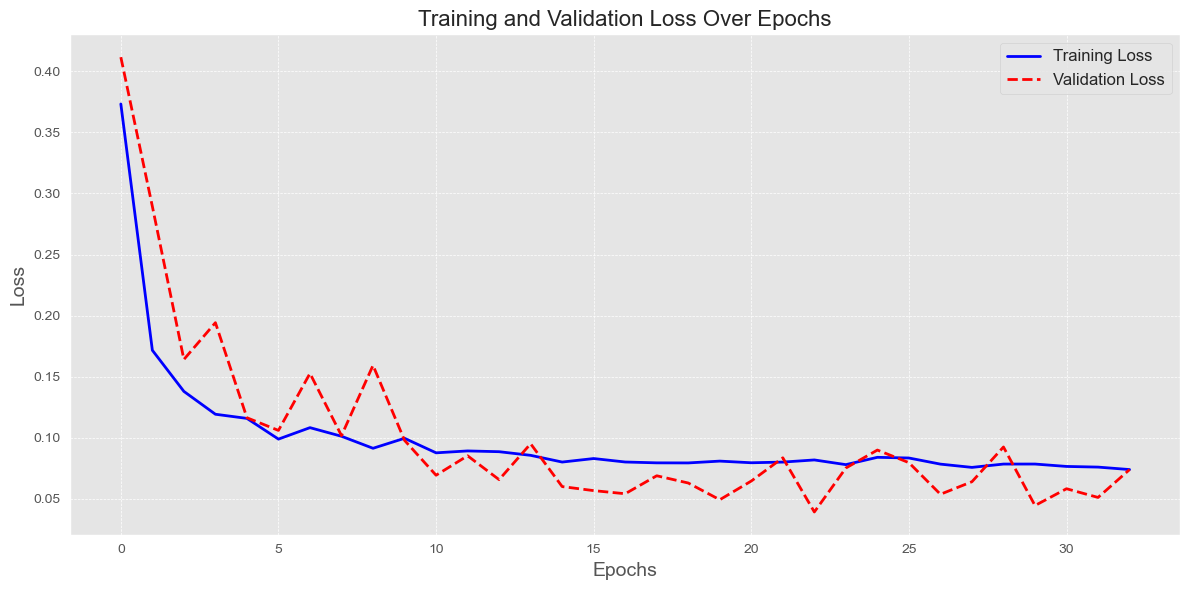

In [35]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed', linewidth=2)
    
    # Setting the title and labels
    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    
    # Display the plot
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Use the function to plot the history
plot_training_history(history)


In [36]:
loss_and_metrics = model.evaluate(x=[X_time_seq_test, X_spatio_test], y=y_test)


64/64 [==============================] - 0s 7ms/step - loss: 0.0393 - mse: 0.0393 - mae: 0.1355


In [38]:
from sklearn.metrics import r2_score

# R2 계산 함수
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# MAPE 계산 함수
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# RMSE 계산 함수
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

# WMAPE 계산 함수 (여기서는 간단하게 평균을 가중치로 사용)
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

# RMSPE 계산 함수
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# 모델 평가
loss, mse, mae = model.evaluate(x=[X_time_seq_test, X_spatio_test], y=y_test)
print("Loss:", loss)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# 예측값 얻기
pred_Y = model.predict([X_time_seq_test, X_spatio_test])

# 추가된 평가 메트릭 값 계산 및 출력
print("R2:", r2(y_test, pred_Y))
print("MAPE:", mape(y_test, pred_Y))
print("RMSE:", rmse(y_test, pred_Y))
print("WMAPE:", wmape(y_test, pred_Y))
print("RMSPE:", rmspe(y_test, pred_Y))


64/64 [==============================] - 0s 7ms/step - loss: 0.0393 - mse: 0.0393 - mae: 0.1355
Loss: 0.03929154574871063
Mean Squared Error: 0.03929154574871063
Mean Absolute Error: 0.1355229616165161
64/64 [==============================] - 1s 8ms/step
R2: 0.9579892418912168
MAPE: 475.1435177317921
RMSE: 1.3069919572916602
WMAPE: 935303.3206640928
RMSPE: 31.324321992465258


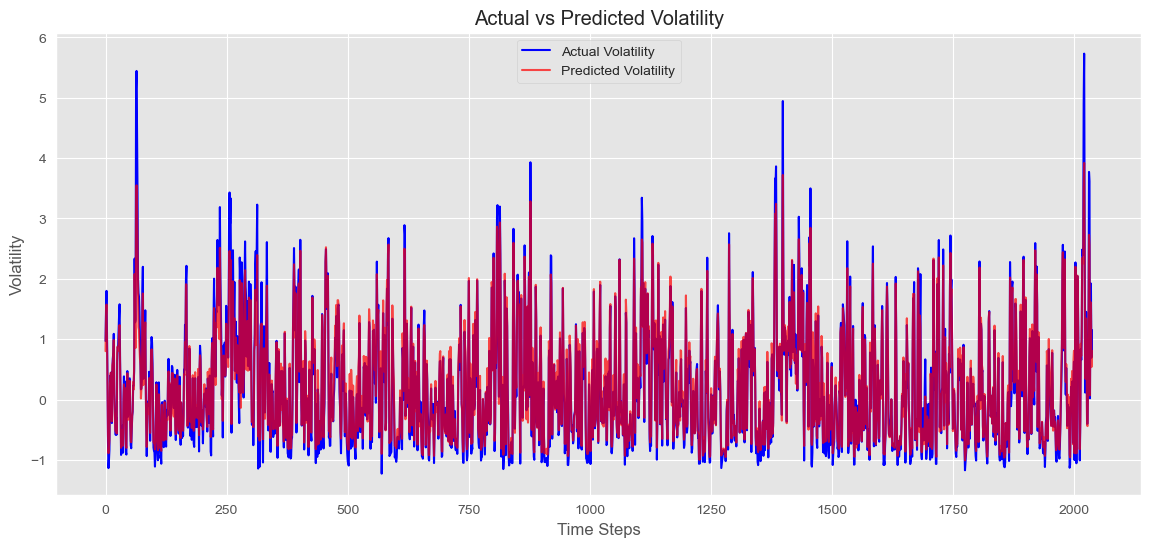

In [39]:
# Plotting the actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Volatility', color='blue')
plt.plot(pred_Y, label='Predicted Volatility', color='red', alpha=0.7)
plt.title('Actual vs Predicted Volatility')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()